In [3]:
import pandas as pd
import torch
import glob

import seaborn as sns

In [4]:
import sys
sys.path.append("../src")

import train

In [5]:
from types import SimpleNamespace
sns.set_context('talk')

# Results

In [6]:
paths = glob.glob("../experiments/weinreb-interpolate-train_batch-0.1/"
          "/*/*/interpolate.log")
baseline1 = 29.9975
baseline2 = 31.1015

results = []
for path in paths: 
    log = pd.read_csv(path, sep = '\t')
    log = log.loc[log['epoch'] != 'best']
    log['epoch'] = log['epoch'].apply(lambda e: int(e.split('_')[1]))

    config = torch.load(path.replace('interpolate.log', 'config.pt'))
    k_dim = config['k_dim']
    tau = config['train_tau']
    lr = config['train_lr']
    seed = config['seed']
    weight = config['weight']

    log = log.set_index(['epoch', 'eval'])['loss'].unstack()
    
    last = log.tail(n = 1)
    last_train = last['train'].item()
    last_test = last['test'].item()    
    
    best = log.sort_values('train').head(n = 1)
    best_train = best['train'].item()
    best_test = best['test'].item()

    results.append((k_dim, tau, lr, weight, seed, best_train, best_test, last_train, last_test))
    
results = pd.DataFrame(results, columns = ['k_dim', 'tau', 'lr', 'weight', 'seed', 
    'best_train', 'best_test', 'last_train', 'last_test'])
#results['relative_best'] = (baseline - results['best_test']) / baseline
#results['relative_last'] = (baseline - results['last_test']) / baseline

# number of experiments
results.groupby(['k_dim', 'tau', 'lr', 'weight'])['best_train'].count()

k_dim  tau           lr     weight
200    1.000000e-09  0.010  d26       5
                            none      5
       1.000000e-06  0.010  d26       5
                            none      5
       1.000000e-03  0.010  d26       5
                            none      5
400    1.000000e-09  0.005  d26       5
                            none      5
                     0.010  d26       5
                            none      5
       1.000000e-06  0.005  d26       5
                            none      5
                     0.010  d26       5
                            none      5
       1.000000e-03  0.005  d26       5
                            none      5
                     0.010  d26       5
                            none      5
1000   1.000000e-09  0.010  d26       5
                            none      5
       1.000000e-06  0.010  d26       5
                            none      5
       1.000000e-03  0.010  d26       5
                            none      5
4000 

In [7]:
results.groupby(['k_dim', 'tau', 'lr', 'weight'])['best_train'].mean().unstack()

weight                          d26       none
k_dim tau          lr                         
200   1.000000e-09 0.010  17.174110  16.334329
      1.000000e-06 0.010  15.823456  15.884330
      1.000000e-03 0.010  29.914149  31.658745
400   1.000000e-09 0.005  16.782281  16.056472
                   0.010  18.836664  16.177296
      1.000000e-06 0.005  16.049575  15.232354
                   0.010  17.431239  15.158942
      1.000000e-03 0.005  27.453305  25.331097
                   0.010  33.345631  36.908154
1000  1.000000e-09 0.010  17.514907  16.609705
      1.000000e-06 0.010  16.986612  15.567277
      1.000000e-03 0.010  63.605161  60.527418
4000  1.000000e-09 0.005  19.903984  18.818871
      1.000000e-06 0.005  19.000232  17.816490
      1.000000e-03 0.005  71.451343  68.623143

In [8]:
results.groupby(['k_dim', 'tau', 'lr', 'weight'])['best_test'].mean().unstack()

weight                           d26       none
k_dim tau          lr                          
200   1.000000e-09 0.010   28.230984  27.401958
      1.000000e-06 0.010   27.114855  25.781794
      1.000000e-03 0.010   89.112738  80.130458
400   1.000000e-09 0.005   27.641225  26.304312
                   0.010   30.037628  27.220210
      1.000000e-06 0.005   26.823165  25.309965
                   0.010   28.790331  25.625756
      1.000000e-03 0.005  117.305040  89.708682
                   0.010   69.578635  63.229137
1000  1.000000e-09 0.010   29.408652  28.504958
      1.000000e-06 0.010   28.113019  26.911786
      1.000000e-03 0.010   53.557883  49.755132
4000  1.000000e-09 0.005   31.273230  29.455504
      1.000000e-06 0.005   29.729528  28.086852
      1.000000e-03 0.005   54.187169  50.604143

Write to latex tables

In [30]:
#k_lr = [(1000, 0.01), (4000, 0.005), (200, 0.01), (400, 0.005)]
k, lr = (400, 0.005)
#tau = 1e-3

for weight in ['none', 'd26']: 
    for tau in [1e-3, 1e-6, 1e-9]:
    

        select_k = results['k_dim'] == k
        select_tau = results['tau'] == tau
        select_lr = results['lr'] == lr
        select_weight = results['weight'] == weight
        select = select_k & select_tau & select_lr & select_weight

        rm = results.loc[select, 'best_train'].mean()
        rs = results.loc[select, 'best_train'].std()

        print('{:.2f} $\pm$ {:.2f} &'.format(rm, rs))

25.33 $\pm$ 3.21 &
15.23 $\pm$ 0.30 &
16.06 $\pm$ 0.44 &
27.45 $\pm$ 6.41 &
16.05 $\pm$ 0.42 &
16.78 $\pm$ 0.49 &


Calculate number of parameters

In [5]:
cg = SimpleNamespace(**config)

cg.layers = 2
cg.k_dim = 200
model = train.AutoGenerator(cg)
sum(p.numel() for p in model.parameters())

50600

In [6]:
cg.layers = 1
cg.k_dim = 1000
model = train.AutoGenerator(cg)
sum(p.numel() for p in model.parameters())

52000

In [7]:
cg = SimpleNamespace(**config)

cg.layers = 2
cg.k_dim = 400
model = train.AutoGenerator(cg)
sum(p.numel() for p in model.parameters())

181200

In [8]:
cg.layers = 1
cg.k_dim = 4000
model = train.AutoGenerator(cg)
sum(p.numel() for p in model.parameters())

208000

Show impact of architecture (for fixed tau = 1e-6)

Text(0.5, 15.439999999999998, '')

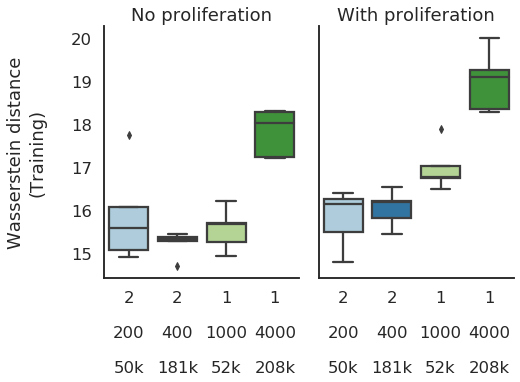

In [26]:
p = results.loc[results['tau'] == 1e-6]
p = p.loc[~((p['k_dim'] == 400) & (p['lr'] == 0.01))]

sns.set_style("white")

g = sns.catplot(kind = 'box', data = p, x = 'k_dim', y = 'best_train', col = 'weight', 
            order = [200, 400, 1000, 4000], aspect = 0.7, 
            palette = 'Paired')
g.axes[0][0].set_ylabel('Wasserstein distance\n(Training)\n')

g.axes[0][0].set_title('No proliferation')
g.axes[0][1].set_title('With proliferation')

g.axes[0][1].set_xticklabels(
    ['2\n\n200\n\n50k', '2\n\n400\n\n181k', 
     '1\n\n1000\n\n52k', '1\n\n4000\n\n208k'])
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('')

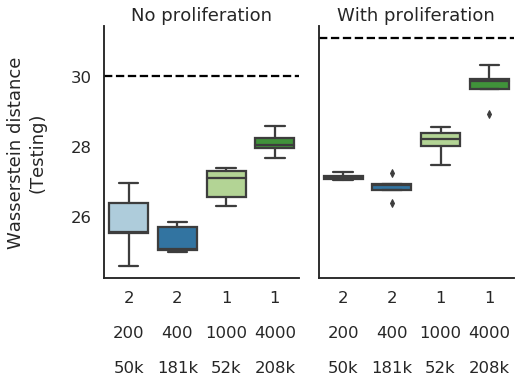

In [27]:
p = results.loc[results['tau'] == 1e-6]
p = p.loc[~((p['k_dim'] == 400) & (p['lr'] == 0.01))]

sns.set_style("white")

g = sns.catplot(kind = 'box', data = p, x = 'k_dim', y = 'best_test', col = 'weight', 
            order = [200, 400, 1000, 4000], aspect = 0.7, 
            palette = 'Paired')
g.axes[0][0].set_ylabel('Wasserstein distance\n(Testing)\n')

g.axes[0][0].set_title('No proliferation')
g.axes[0][1].set_title('With proliferation')

g.axes[0][1].set_xticklabels(
    ['2\n\n200\n\n50k', '2\n\n400\n\n181k', 
     '1\n\n1000\n\n52k', '1\n\n4000\n\n208k'])
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('')

g.axes[0][0].axhline(29.9975, color = 'k', linestyle = 'dashed')
g.axes[0][1].axhline(31.1015, color = 'k', linestyle = 'dashed')

Show impact of tau (for fixed architecture)

Text(0.5, 15.439999999999998, '')

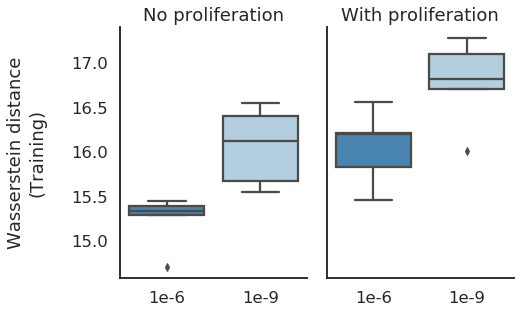

In [19]:
p = results.loc[(results['k_dim'] == 400) & (results['lr'] == 0.005)]
g = sns.catplot(kind = 'box', data = p, x = 'tau', y = 'best_train', col = 'weight', 
    order = [1e-6, 1e-9], aspect = 0.7, palette = 'Blues_r')

g.axes[0][0].set_ylabel('Wasserstein distance\n(Training)\n')

g.axes[0][0].set_title('No proliferation')
g.axes[0][1].set_title('With proliferation')

g.axes[0][1].set_xticklabels(['1e-6', '1e-9'])
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('')


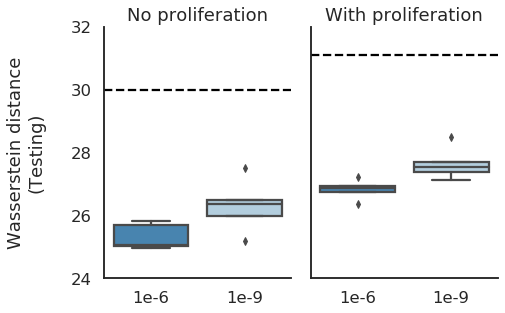

In [20]:
p = results.loc[(results['k_dim'] == 400) & (results['lr'] == 0.005)]
g = sns.catplot(kind = 'box', data = p, x = 'tau', y = 'best_test', col = 'weight', 
    order = [1e-6, 1e-9], aspect = 0.7, palette = 'Blues_r')
g.axes[0][0].set_ylim([24, 32])
g.axes[0][1].set_ylim([24, 32])

g.axes[0][0].set_ylabel('Wasserstein distance\n(Testing)\n')

g.axes[0][0].set_title('No proliferation')
g.axes[0][1].set_title('With proliferation')

g.axes[0][1].set_xticklabels(['1e-6', '1e-9'])
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('')

g.axes[0][0].axhline(29.9975, color = 'k', linestyle = 'dashed')
g.axes[0][1].axhline(31.1015, color = 'k', linestyle = 'dashed')

Text(0.5, 15.439999999999998, '')

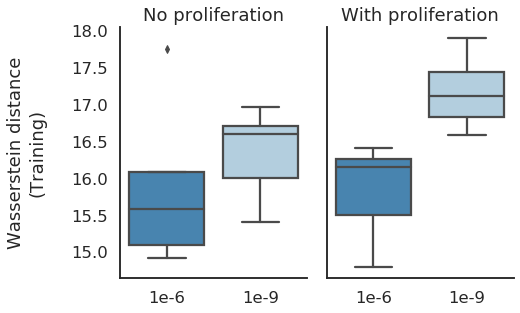

In [22]:
p = results.loc[(results['k_dim'] == 200) & (results['lr'] == 0.01)]
g = sns.catplot(kind = 'box', data = p, x = 'tau', y = 'best_train', col = 'weight', 
    order = [1e-6, 1e-9], aspect = 0.7, palette = 'Blues_r')

g.axes[0][0].set_ylabel('Wasserstein distance\n(Training)\n')

g.axes[0][0].set_title('No proliferation')
g.axes[0][1].set_title('With proliferation')

g.axes[0][1].set_xticklabels(['1e-6', '1e-9'])
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('')


Show wrt baselines (linear interpolation, distance to starting time point, distance to final time point)

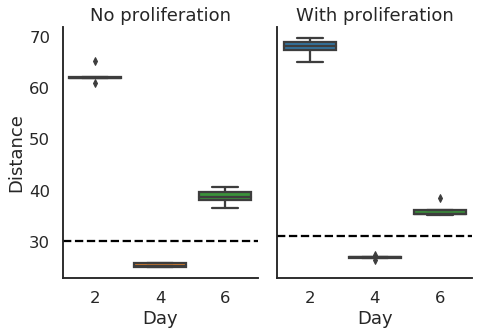

In [42]:
paths = glob.glob("../experiments/weinreb-interpolate-train_batch-0.1/"
          "/*2_400-0.1_0.1_1e-06-0.1_0.1_0.005/*/interpolate.log")

results = []

for path in paths: 
    log = pd.read_csv(path, sep = '\t')
    log = log.loc[log['epoch'] != 'best']
    log['epoch'] = log['epoch'].apply(lambda e: int(e.split('_')[1]))

    config = torch.load(path.replace('interpolate.log', 'config.pt'))
    k_dim = config['k_dim']
    tau = config['train_tau']
    lr = config['train_lr']
    seed = config['seed']
    weight = config['weight']

    log = log.set_index(['epoch', 'eval'])['loss'].unstack()
    
    best = log.sort_values('train').head(n = 1)
    best_train = best['train'].item()
    best_test = best['test'].item()

    log = pd.read_csv(path.replace('interpolate.log', 'baseline.log'), sep = '\t')
    log = log.loc[log['epoch'] != 'best']
    log['epoch'] = log['epoch'].apply(lambda e: int(e.split('_')[1]))
    log = log.set_index('epoch')
    log = log.loc[best.index].unstack().reset_index().drop('epoch', axis = 1)
    log.columns = ['Day', 'Distance']
    log['seed'] = seed
    log['weight'] = weight
    
    results.append(log)
    
results = pd.concat(results)    

g = sns.catplot(kind = 'box', data = results, x = 'Day', 
    y = 'Distance', col = 'weight',
    aspect = 0.7)
g.axes[0][0].set_title('No proliferation')
g.axes[0][1].set_title('With proliferation')

g.axes[0][0].axhline(29.9975, color = 'k', linestyle = 'dashed')
g.axes[0][1].axhline(31.1015, color = 'k', linestyle = 'dashed')